# Customer Survival - Churn Prediction

***

> Churn rate is an essential metric to provides clarity on how well the business is retaining customers. An explicit customer churn represents the rate at which your customers are cancelling their subscriptions. On the other hand, the most common situation in retail selling is an implicit churn. This happens when the churner simply stops using the platform/business. 

***

> The purpose of this notebook is trying to predict users who will churn by checking previous historical data.

## Libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

## Dataset

In [2]:
df = pd.read_csv('churn_data.csv')
df.head(20)

,uuid,date,event
0,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-02-07,small_purchase
1,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-02-20,small_purchase
2,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-12,contact
3,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-19,contact
4,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-30,contact
5,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-30,big_purchase
6,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-05-16,small_purchase
7,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-06-05,contact
8,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-06-14,contact
9,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-07-11,contact


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104103 entries, 0 to 104102
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   uuid    104103 non-null  object
 1   date    104103 non-null  object
 2   event   104103 non-null  object
dtypes: object(3)
memory usage: 2.4+ MB


## EDA

In [4]:
print("Number of Events: ",df.shape[0])
print("Number of Unique Users: ",df.uuid.nunique())
print("Type of Events: ", df.event.unique()[0:3].tolist())

Number of Events:  104103
Number of Unique Users:  1034
Type of Events:  ['small_purchase', 'contact', 'big_purchase']


In [5]:
# column date to datetime instead object
# extract more info from date
df['date'] = pd.to_datetime(df['date'])
df['monthYear'] = pd.to_datetime(df['date'],format='%Y-%m-%d').dt.to_period('M')
df['month'] = pd.to_datetime(df['date'],format='%Y-%m-%d').dt.month
df['year'] = pd.to_datetime(df['date'],format='%Y-%m-%d').dt.year
df['week'] = pd.to_datetime(df['date'],format='%Y-%m-%d').dt.week

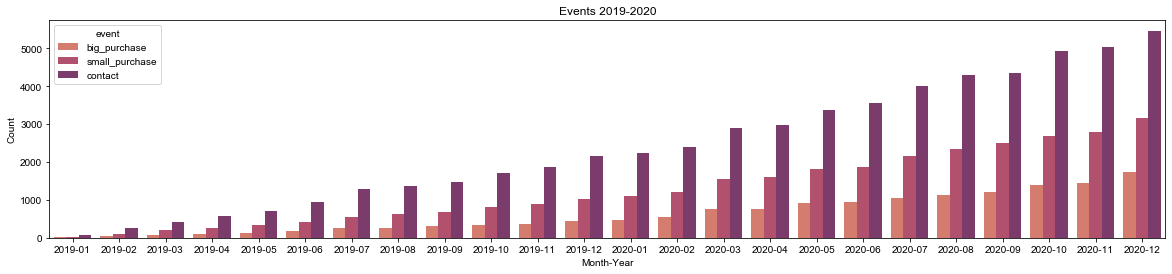

In [6]:
plt.figure(figsize=(20,4))
ax = sns.countplot(data=df.sort_values(by='monthYear',ascending=True),x="monthYear", 
                   hue="event",hue_order=['big_purchase','small_purchase','contact']
                   ,palette="flare")
sns.set(style="whitegrid")
plt.xlabel('Month-Year')
plt.ylabel('Count')
plt.title('Events 2019-2020')
plt.show()

## Interval Between Events / Cut Off Date

In [7]:
df['interval'] = df.groupby('uuid')['date'].diff().apply(lambda x: x.days)

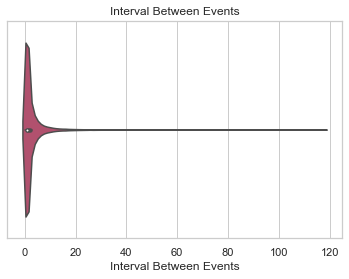

In [8]:
ax = sns.violinplot(data=df, x='interval',palette='flare')
plt.xlabel('Interval Between Events')
plt.title('Interval Between Events')
plt.show()

Calculating the optimal cut off date for determine customers that churned

In [9]:
def calcChurnFP(interval):
    falsePositive = df[df.interval > interval]['uuid'].nunique()
    return print("False Positive:",falsePositive)

def calcChurnFPPerc(interval):
    falsePositive = df[df.interval > interval]['uuid'].nunique()
    numberUsers = df.uuid.nunique()
    return print("Percentage:",round((falsePositive/numberUsers)*100,2))

In [10]:
#calculating FP depending of interval
for i in range(60,95,5):
    print("Interval:",i," days")
    calcChurnFP(i)
    calcChurnFPPerc(i)
    print("-----------------------")

Interval: 60  days
False Positive: 40
Percentage: 3.87
-----------------------
Interval: 65  days
False Positive: 27
Percentage: 2.61
-----------------------
Interval: 70  days
False Positive: 21
Percentage: 2.03
-----------------------
Interval: 75  days
False Positive: 13
Percentage: 1.26
-----------------------
Interval: 80  days
False Positive: 8
Percentage: 0.77
-----------------------
Interval: 85  days
False Positive: 5
Percentage: 0.48
-----------------------
Interval: 90  days
False Positive: 3
Percentage: 0.29
-----------------------


## Feature Engineering

In [11]:
# categorical column
df.event.value_counts()

contact           58406
small_purchase    30741
big_purchase      14956
Name: event, dtype: int64

In [12]:
# categorical to numeric
eventsClass = {'contact': 1,'small_purchase': 2,'big_purchase': 3 }
df['eventsClass'] = df.event.replace(eventsClass)
df.head()

,uuid,date,event,monthYear,month,year,week,interval,eventsClass
0,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-02-07,small_purchase,2019-02,2,2019,6,NaN,2
1,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-02-20,small_purchase,2019-02,2,2019,8,13.0,2
2,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-12,contact,2019-04,4,2019,15,51.0,1
3,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-19,contact,2019-04,4,2019,16,7.0,1
4,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-30,contact,2019-04,4,2019,18,11.0,1


In [13]:
# count number of events
df['eventNumber'] = df.groupby('uuid').cumcount()
df.head()

,uuid,date,event,monthYear,month,year,week,interval,eventsClass,eventNumber
0,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-02-07,small_purchase,2019-02,2,2019,6,NaN,2,0
1,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-02-20,small_purchase,2019-02,2,2019,8,13.0,2,1
2,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-12,contact,2019-04,4,2019,15,51.0,1,2
3,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-19,contact,2019-04,4,2019,16,7.0,1,3
4,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-30,contact,2019-04,4,2019,18,11.0,1,4


In [14]:
# count number of events by month
eventsMonth = df.groupby(['uuid','monthYear']).size().reset_index(name='numEventsMonth')
eventsMonth.head()

,uuid,monthYear,numEventsMonth
0,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-02,2
1,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04,4
2,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-05,1
3,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-06,2
4,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-07,2


In [15]:
df = pd.merge(df,eventsMonth,how='left',on=['uuid','monthYear'])
df.head()

,uuid,date,event,monthYear,month,year,week,interval,eventsClass,eventNumber,numEventsMonth
0,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-02-07,small_purchase,2019-02,2,2019,6,NaN,2,0,2
1,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-02-20,small_purchase,2019-02,2,2019,8,13.0,2,1,2
2,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-12,contact,2019-04,4,2019,15,51.0,1,2,4
3,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-19,contact,2019-04,4,2019,16,7.0,1,3,4
4,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-30,contact,2019-04,4,2019,18,11.0,1,4,4


In [16]:
# count purchase events by month
purchaseFilter = df.eventsClass != 1
purchaseMonth = df[purchaseFilter].groupby(['uuid','monthYear']).size().reset_index(name='purchaseMonth')
purchaseMonth.head()

,uuid,monthYear,purchaseMonth
0,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-02,2
1,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04,1
2,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-05,1
3,0012c23d-379a-43fb-a91b-6f95c5358f52,2019-11,2
4,0012c23d-379a-43fb-a91b-6f95c5358f52,2019-12,2


In [17]:
df = pd.merge(df,purchaseMonth,how='left',on=['uuid','monthYear'])
df.fillna(0,inplace=True)
df.head()

,uuid,date,event,monthYear,month,year,week,interval,eventsClass,eventNumber,numEventsMonth,purchaseMonth
0,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-02-07,small_purchase,2019-02,2,2019,6,0.0,2,0,2,2.0
1,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-02-20,small_purchase,2019-02,2,2019,8,13.0,2,1,2,2.0
2,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-12,contact,2019-04,4,2019,15,51.0,1,2,4,1.0
3,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-19,contact,2019-04,4,2019,16,7.0,1,3,4,1.0
4,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-30,contact,2019-04,4,2019,18,11.0,1,4,4,1.0


In [18]:
# count contact events by month
contactFilter = df.eventsClass == 1
contactMonth = df[contactFilter].groupby(['uuid','monthYear']).size().reset_index(name='contactMonth')
contactMonth.head()

,uuid,monthYear,contactMonth
0,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04,3
1,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-06,2
2,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-07,2
3,0012c23d-379a-43fb-a91b-6f95c5358f52,2019-09,1
4,0012c23d-379a-43fb-a91b-6f95c5358f52,2019-10,1


In [19]:
df = pd.merge(df,contactMonth,how='left',on=['uuid','monthYear'])
df.fillna(0,inplace=True)
df.head()

,uuid,date,event,monthYear,month,year,week,interval,eventsClass,eventNumber,numEventsMonth,purchaseMonth,contactMonth
0,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-02-07,small_purchase,2019-02,2,2019,6,0.0,2,0,2,2.0,0.0
1,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-02-20,small_purchase,2019-02,2,2019,8,13.0,2,1,2,2.0,0.0
2,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-12,contact,2019-04,4,2019,15,51.0,1,2,4,1.0,3.0
3,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-19,contact,2019-04,4,2019,16,7.0,1,3,4,1.0,3.0
4,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-30,contact,2019-04,4,2019,18,11.0,1,4,4,1.0,3.0


In [20]:
# count number of events on the last 7 days
eventsLast7D = df.groupby(['uuid','year','week']).size().reset_index(name='numEventsLast7D')
eventsLast7D.head()

,uuid,year,week,numEventsLast7D
0,00038504-c286-4c49-a6ed-d7853f65f7d6,2019,6,1
1,00038504-c286-4c49-a6ed-d7853f65f7d6,2019,8,1
2,00038504-c286-4c49-a6ed-d7853f65f7d6,2019,15,1
3,00038504-c286-4c49-a6ed-d7853f65f7d6,2019,16,1
4,00038504-c286-4c49-a6ed-d7853f65f7d6,2019,18,2


In [21]:
df = pd.merge(df,eventsLast7D,how='left',on=['uuid','year','week'])
df.head()

,uuid,date,event,monthYear,month,year,week,interval,eventsClass,eventNumber,numEventsMonth,purchaseMonth,contactMonth,numEventsLast7D
0,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-02-07,small_purchase,2019-02,2,2019,6,0.0,2,0,2,2.0,0.0,1
1,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-02-20,small_purchase,2019-02,2,2019,8,13.0,2,1,2,2.0,0.0,1
2,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-12,contact,2019-04,4,2019,15,51.0,1,2,4,1.0,3.0,1
3,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-19,contact,2019-04,4,2019,16,7.0,1,3,4,1.0,3.0,1
4,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-30,contact,2019-04,4,2019,18,11.0,1,4,4,1.0,3.0,2


## Churn Classification

In [22]:
# calling the last date of each user as "last"
# classifying the other dates before the last as 0
indexLastDate = df.groupby('uuid', as_index=False).nth(-1).index
df['churn'] = ['last' if x in indexLastDate else 0 for x in df.index]

In [23]:
from datetime import date

dayCalcChurn = pd.to_datetime(date(2021,1,1)) #first day of 2021 - to calculate probability of churn

daysLastEvent = []
for i in range(0,len(df)):
    diffDaysLast = abs(dayCalcChurn - df.date[i]).days
    daysLastEvent.append(diffDaysLast)

df['days_last_event'] = daysLastEvent 


In [24]:
# classifyng churn (1's) on ds
cutOffDate = 90
cond1 = df.churn == 'last'
cond2 = df.days_last_event > cutOffDate
df.loc[cond1 & cond2,'churn'] = 1


In [25]:
df.churn.value_counts()

0       103069
last       719
1          315
Name: churn, dtype: int64

In this scenario, we have 103069 not churn events, 315 churn events and 719 events that we don't know how to classify yet.

## Undersampling & Oversampling

In [26]:
# the known values will be used for train and valid dataset
trainValid = df.loc[df.churn != 'last']
trainValid = trainValid[['month','interval','eventsClass','eventNumber',
                         'numEventsMonth','purchaseMonth','churn']]
print("Shape of Train + Valid dataset:",trainValid.shape)

Shape of Train + Valid dataset: (103384, 7)


In [27]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(trainValid.drop(columns=['churn']),trainValid['churn'], test_size=0.3,random_state=42)
print("Shape of X Train dataset: ",X_train.shape)
print("Shape of y Train dataset: ",y_train.shape)
print("Shape of X Valid dataset: ",X_valid.shape)
print("Shape of y Valid dataset: ",y_valid.shape)

Shape of X Train dataset:  (72368, 6)
Shape of y Train dataset:  (72368,)
Shape of X Valid dataset:  (31016, 6)
Shape of y Valid dataset:  (31016,)


### Applying RandomUnderSampling in majority class

In [28]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42,sampling_strategy=0.01)

In [29]:
X_train_res, y_train_res = rus.fit_resample(X_train, y_train.astype('int'))
X_valid_res, y_valid_res = rus.fit_resample(X_valid, y_valid.astype('int'))
print("Shape of X Train dataset: ",X_train_res.shape)
print("Shape of y Train dataset: ",y_train_res.shape)
print("Shape of X Valid dataset: ",X_valid_res.shape)
print("Shape of y Valid dataset: ",y_valid_res.shape)

Shape of X Train dataset:  (22725, 6)
Shape of y Train dataset:  (22725,)
Shape of X Valid dataset:  (9090, 6)
Shape of y Valid dataset:  (9090,)


### Applying SMOTE to implement oversampling

In [30]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42,sampling_strategy=1.0)

In [31]:
X_train_res, y_train_res = sm.fit_resample(X_train_res, y_train_res.astype('int'))
X_valid_res, y_valid_res = sm.fit_resample(X_valid_res, y_valid_res.astype('int'))
print("Shape of X Train dataset: ",X_train_res.shape)
print("Shape of y Train dataset: ",y_train_res.shape)
print("Shape of X Valid dataset: ",X_valid_res.shape)
print("Shape of y Valid dataset: ",y_valid_res.shape)

Shape of X Train dataset:  (45000, 6)
Shape of y Train dataset:  (45000,)
Shape of X Valid dataset:  (18000, 6)
Shape of y Valid dataset:  (18000,)


In [32]:
# test dataset will alocate the unknown values that will be used for prediction
test = df.loc[df.churn == 'last']
X_test = test[['month','interval','eventsClass','eventNumber','numEventsMonth','purchaseMonth']]
print("Shape of Test dataset:",X_test.shape)

Shape of Test dataset: (719, 6)


## Model Validation

In [33]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score,recall_score, f1_score
import scikitplot as skplt

In [34]:
names = ["Nearest_Neighbors","Decision_Tree", "Random_Forest","AdaBoost","Naive_Bayes"]

classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=100),
    AdaBoostClassifier(n_estimators=100),
    GaussianNB()]

In [35]:
scores = []
for name, clf in zip(names, classifiers):
    clf.fit(X_train_res, y_train_res.astype('int'))
    prediction = clf.predict(X_valid_res)
    score = precision_score(y_valid_res.astype('int'),prediction )
    scores.append(score)

models = pd.DataFrame()
models['name'] = names
models['score'] = scores
models.sort_values(by='score',ascending=False)

,name,score
3,AdaBoost,0.966508
0,Nearest_Neighbors,0.960275
2,Random_Forest,0.953420
1,Decision_Tree,0.944161
4,Naive_Bayes,0.928404


In [36]:
best_model = AdaBoostClassifier(n_estimators=100)


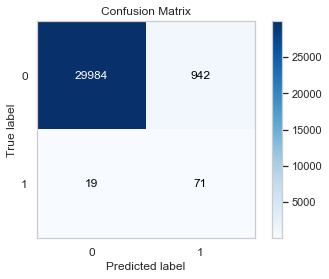

In [37]:
best_model.fit(X_train_res, y_train_res.astype('int'))
prediction = best_model.predict(X_valid)
skplt.metrics.plot_confusion_matrix(y_valid.astype('int'),prediction)
plt.title("Confusion Matrix")
plt.show()

In [38]:
# now we will predict the values that we don't know if users churn or not
churnPredict = best_model.predict(X_test)

In [39]:
len(churnPredict)

719

In [40]:
#substituting for the values predicted by the model in the dataframe
df.loc[df.churn == 'last','churn'] = churnPredict

In [41]:
df.churn.value_counts()

0    103683
1       420
Name: churn, dtype: int64